In [1]:
import sys
sys.path.append('../src/')
import thumbstack
from thumbstack import *
from my_functions import cutting, mapping, masking
import numpy as np
from pixell import enmap
import mass_conversion
from mass_conversion import *
import matplotlib.pyplot as plt

In [12]:
def binning(table_name, n_bins, gal_property, add_val=None):
    table = Table.read(table_name+'.fits', format='fits')

    # sort table based on the property provided
    sorted_tab = table[table[gal_property].argsort()]
    
    # get how many galaxies will be in each bin
    length = len(table)
    base_value = length // n_bins
    remainder = length % n_bins
    bins = [base_value + 1 if i < remainder else base_value for i in range(n_bins)] #list of bin amount

    original = []
    original = ['RA', 'DEC', 'Z', 'LOGM', 'LOGSFR', 'AGNLUM']

    if add_val != None:
        for i in range(len(add_val)):
            while add_val[i] not in original:
                original.append(add_val[i])

    if gal_property not in original:
        original.append(gal_property)

    out_add_val = {'n_objects': bins}
    for name in original:
        #print(name)
        outMin = name + '_min'
        outMax = name + '_max'
        out_add_val[outMin] = []
        out_add_val[outMax] = []
    
    starting = 0
    for i in range(n_bins):
        ending = starting + bins[i]
        
        cut_table = Table() #clears out table from prev loop
        cut_table = sorted_tab[starting:ending]

        starting += bins[i]

        for name in original:
            outMin = outMin = name + '_min'
            outMax = name + '_max'
            out_add_val[outMin].extend([cut_table[name].min()])
            out_add_val[outMax].extend([cut_table[name].max()])

    new_tab = Table(out_add_val)

    return new_tab

binning('FujiBGSPhysProp_v1.1',3,'CHI2_1', ['CHI2_1', 'RA'])

n_objects,RA_min,RA_max,DEC_min,DEC_max,Z_min,Z_max,LOGM_min,LOGM_max,LOGSFR_min,LOGSFR_max,AGNLUM_min,AGNLUM_max,CHI2_1_min,CHI2_1_max
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
142089,2.4486721240583917,357.8065633418584,-31.564040731606124,84.60913972807091,0.00229671014539556,3.717442240688935,5.252458118512384,12.138247577717285,-22.7091971527532,3.141231221184469,1.1139435471102244e+20,1.4735037348984055e+40,1.229256392733966,1.7154707450370268
142089,2.425248603761992,357.7608481825155,-31.567106315770555,84.59239577569451,0.0010566201675521122,4.432279621540782,4.314297592227383,12.280478708449797,-27.690470606976405,4.083387950135478,1935026180.1051877,2.671662543799573e+40,1.7154749734030839,2.8527704186347815
142089,2.4135933394132487,357.77270250439847,-31.59252659529466,84.59029582336292,0.0012099037495134737,5.193372238541532,4.444649764600156,13.138921044094747,-28.223261274806394,4.274934366575584,230563.7007796219,1.0111045750143736e+41,2.8527814448455886,16.99749910733301


In [44]:
original = ['RA', 'DEC', 'Z', 'LOGM', 'LOGSFR', 'AGNLUM']
other = []
#add_val = ['CHI2_1', 'LOGM_ERR']
add_val = None

if add_val != None:
    for i in range(len(add_val)):
        original.append(add_val[i])

#list_names = ["list1", "list2", "list3"]
out_add_val = {}

# Create empty lists using string names
for name in original:
    outMin = name + '_min'
    outMax = name + '_max'
    out_add_val[outMin] = []
    out_add_val[outMax] = []

for i in range(0,2):
    for name in original:
        outMin = outMin = name + '_min'
        outMax = name + '_max'
        out_add_val[outMin].extend([i])
        out_add_val[outMax].extend([i+1])
out_add_val

{'RA_min': [0, 1],
 'RA_max': [1, 2],
 'DEC_min': [0, 1],
 'DEC_max': [1, 2],
 'Z_min': [0, 1],
 'Z_max': [1, 2],
 'LOGM_min': [0, 1],
 'LOGM_max': [1, 2],
 'LOGSFR_min': [0, 1],
 'LOGSFR_max': [1, 2],
 'AGNLUM_min': [0, 1],
 'AGNLUM_max': [1, 2]}

In [3]:
def stacked_plot(catalog_name, cmb_map, mask, n_bins, gal_property, name):
    
    # run binning
    boundaries = binning(catalog_name, n_bins, gal_property, tabled=True)

    # run thumbstack with 
    for i in range(n_bins):
        outName = name + '_bin' + str(i+1)
        this_min = gal_property + '_min'
        this_max = gal_property + '_max'
        prop_dict = {} # clears dictionary from prev loop
        prop_dict = {gal_property: [boundaries[this_min][i], boundaries[this_max][i]]}

        ThumbStack(cutting(catalog_name, prop_dict), 
                   cmb_map, 
                   mask, 
                   name=outName,
                   nameLong=None, 
                   save=True, 
                   nProc=32,
                   filterTypes='ringring2',
                   #doMBins=False, 
                   doBootstrap=True,
                   # doStackedMap=True,
                   #doVShuffle=False, 
                   #cmbNu=cmap.nu, 
                   #cmbUnitLatex=cmap.unitLatex,
                   pathOut='')
    
    # plotting
    plt.figure()
    for i in range(n_bins):
        fits_name = 'figures/thumbstack/' + name + '_bin' + str(i+1) + '/ringring2_tsz_uniformweight.fits'
        fits_file = Table.read(fits_name, format='fits')
        cap_name = 'bin ' + str(i+1)
        plt.errorbar(fits_file['R'], fits_file['T'], yerr = fits_file['error'], alpha=0.4, label=cap_name)
    
    plt.xlabel(r'$R$ [arcmin]')
    plt.ylabel(r'$T$ [$\mu K\cdot\mathrm{arcmin}^2$]')
    plt.legend()
    
    fig_name=name+'_profile.png'
    plt.savefig(fig_name)
    
    plt.show()
    
    return

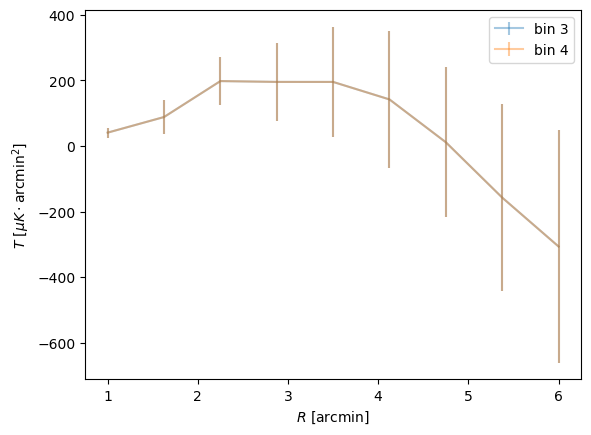

In [17]:
# ex plot
name = 'act_test'
plt.figure()
for i in range(3,5):
    fits_name = 'figures/thumbstack/' + name + str(i) + '/diskring_tsz_uniformweight.fits'
    fits_file = Table.read(fits_name, format='fits')
    cap_name = 'bin ' + str(i)
    plt.errorbar(fits_file['R'], fits_file['T'], yerr = fits_file['error'], alpha=0.4, label=cap_name)

plt.xlabel(r'$R$ [arcmin]')
plt.ylabel(r'$T$ [$\mu K\cdot\mathrm{arcmin}^2$]')
plt.legend()

fig_name=name+'_profile.png'
plt.savefig(fig_name)

plt.show()

In [4]:
binning('FujiBGSPhysProp_v1.1', 8, 'RA', tabled=True)

n_galaxies,RA_min,RA_max,LOGM_min,LOGM_max,LOGSFR_min,LOGSFR_max,AGNLUM_min,AGNLUM_max
int64,float64,float64,float64,float64,float64,float64,float64,float64
53284,2.4135933394132487,116.57281285698743,5.186466125893533,13.138921044094747,-25.135321291401723,3.555474311573235,1.25916009903467e+21,8.213239150406978e+40
53284,116.57306328377523,156.3864979181957,4.314297592227383,12.344757615896405,-23.838922339300943,4.0136991730480736,1.3439428891998289e+22,1.6130566857520769e+40
53284,156.38729777850082,179.78400127254594,4.916750173181314,12.629670889487581,-24.990578114178568,3.9944116663501044,1.1200749628603338e+16,4.076219764805185e+40
53283,179.78409307900333,192.94197984772842,4.816532275957367,12.093359908337826,-23.65419033476585,4.274934366575584,3180720932.304336,9.997376927217544e+40
53283,192.9424256930699,212.91251212253778,4.444649764600156,12.265495598667647,-26.852317353228255,4.083387950135478,4.324392771094892e+20,1.0111045750143736e+41
53283,212.91265925039067,218.79835038049833,4.917915507662218,12.03272950708486,-26.10629561397917,4.0699012920929025,78128090498391.45,6.579411099158795e+40
53283,218.79844246889712,244.1669957610653,5.142419952089013,12.085644672595812,-27.2325828217146,3.595899869296777,3.870895701568383e+19,2.680378371490669e+40
53283,244.16709506391896,357.8065633418584,5.012098823384374,12.033564654792158,-28.223261274806394,4.089956434890958,230563.7007796219,4.390343883668819e+40


In [5]:
new=cutting('FujiBGSPhysProp_v1.1', {'RA':[0,116.57281285698743]}, save=True, name='in_8_test')
new

- Property boundaries applied


TARGETID,SURVEY,PROGRAM,HEALPIX,SPECTYPE_1,RA,DEC,RELEASE_1,Z,CHI2_1,LOGM,LOGM_ERR,LOGSFR,LOGSFR_ERR,AGNLUM,AGNFRAC,AGNPSY,LNU_U,LNU_G,LNU_R,LNU_I,LNU_Z,NUVR,RK,UV,VJ,GR,LNU_U_ERR,LNU_G_ERR,LNU_R_ERR,LNU_I_ERR,LNU_Z_ERR,NUVR_ERR,RK_ERR,UV_ERR,VJ_ERR,GR_ERR,FLAG_MASSPDF,FLAG_SFRPDF,FLAGOPTICAL,FLAGINFRARED,FLUX_G_1,FLUX_R_1,FLUX_Z_1,FLUX_W1_1,FLUX_W2_1,FLUX_W3,FLUX_W4,FLUX_IVAR_G_1,FLUX_IVAR_R_1,FLUX_IVAR_Z_1,FLUX_IVAR_W1_1,FLUX_IVAR_W2_1,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,SNR_R,SNR_G,SNR_Z,SNR_W1,SNR_W2,SNR_W3,SNR_W4,SPGRPVAL,ZERR,ZWARN,CHI2_2,COEFF,NPIXELS,SPECTYPE_2,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE_2,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G_2,FLUX_R_2,FLUX_Z_2,FLUX_W1_2,FLUX_W2_2,FLUX_IVAR_G_2,FLUX_IVAR_R_2,FLUX_IVAR_Z_2,FLUX_IVAR_W1_2,FLUX_IVAR_W2_2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
,,,,,deg,deg,,,,log(solMass),log(solMass),log(solMass/yr),log(solMass/yr),W,,deg,W / Hz,W / Hz,W / Hz,W / Hz,W / Hz,mag,mag,mag,mag,mag,W / Hz,W / Hz,W / Hz,W / Hz,W / Hz,mag,mag,mag,mag,mag,,,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes7,int32,bytes7,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,flo

In [2]:
mapping('act_dr5.01_s08s18_AA_f150_night_map.fits.txt', save=True, save_name='in_8_test_map')

- Map: Importing CMB map
- Map: Remove polarization
- Map: Saving map as in_8_test_map.fits
- Map: Creation Done


ndmap([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[21601.00,7561.00]})

In [4]:
masking('act_dr5.01_s08s18_AA_f150_night_map.fits.txt', 'gal60_mask.fits', 'ps_mask.fits', save=True, save_name='in_8_test_mask')

- Mask: Importing CMB Map
- Mask: Remove Polarization and have all int>1 become 1
- Mask: Importing Point Source Map
- Mask: Importing Planck mask
- Mask: Changing Planck mask to pixell friendly
- Mask: Saving mask as in_8_test_mask.fits
- Mask: Creation Done


ndmap([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[21601.00,7561.00]})

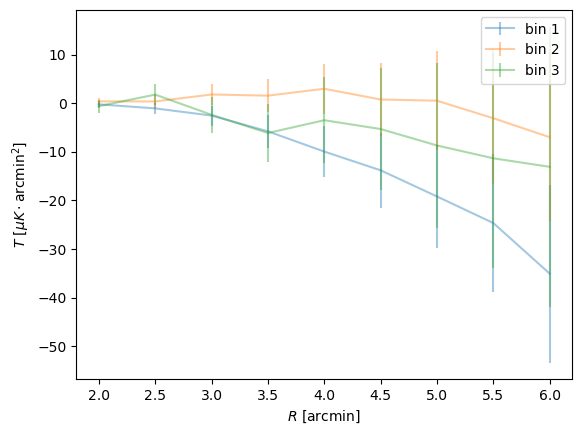

In [5]:
name = 'in_8_test_run'
n_bins=3
plt.figure()
for i in range(n_bins):
    fits_name = 'figures/thumbstack/' + name + '_bin' + str(i+1) + '/ringring2_tsz_uniformweight.fits'
    fits_file = Table.read(fits_name, format='fits')
    cap_name = 'bin ' + str(i+1)
    plt.errorbar(fits_file['R'], fits_file['T'], yerr = fits_file['error'], alpha=0.4, label=cap_name)

plt.xlabel(r'$R$ [arcmin]')
plt.ylabel(r'$T$ [$\mu K\cdot\mathrm{arcmin}^2$]')
plt.legend()

fig_name=name+'_profile.png'
plt.savefig(fig_name)

plt.show()

In [7]:
obj=binning('in_8_test', 3, 'RA', tabled=True)
obj.write('in_8th_3_bins_info.fits', format='fits', overwrite=True)

In [5]:
new_obj=binning('in_8_test', 2, 'LOGM', tabled=True)
new_obj.write('2_mass_bins_from_8.fits', format='fits', overwrite=True)

In [7]:
Table.read('test_runs/2_mass_bins_from_8', format='fits')

n_galaxies,RA_min,RA_max,LOGM_min,LOGM_max,LOGSFR_min,LOGSFR_max,AGNLUM_min,AGNLUM_max
int64,float64,float64,float64,float64,float64,float64,float64,float64
26642,2.440509228223329,116.57281285698743,5.186466125893533,10.369897200348296,-23.080332585122495,2.71857011852522,1.25916009903467e+21,2.441629713245411e+39
26642,2.4135933394132487,116.57160477367734,10.369964244423498,13.138921044094747,-25.135321291401723,3.555474311573235,7.057358998386759e+24,8.213239150406978e+40
